**05 - PyTorch Custom Datasets**

Previously, we looked into building computer vision models with data that was already built into PyTorch such as *FashionMNIST* and *MNIST* datasets. At the same time we also explored a new type of architecture - convolutional neural networks.

The steps that we used to solve these many different problems with these datasets are usually similiar across the board. That's how it is in machine learning. 

We find and pick a dataset to work with, tranform these datasets into numbers, then build a model (or pick an already existing model) to find patterns in these numbers, use these patterns to predict something.

PyTorch has plenty of built-in datasets that can be used for a large range of machine learning benchmarks and there are even plenty more ready-to-use datasets that are assembled by other people. 

However, what if you want to use your own **custom dataset?**

**What is a custom dataset?**

Before we start going deep into things, let's ask the very simple question of what is a custom dataset? 

It's just a collection of data relating to a specific problem that you are trying to solve. So technically speaking, a custom dataset can contain almost anything.

For example, if we want to work with an app that can recognize the faces of your friends and family members then our custom dataset can be contain pictures of their faces. 

We're not even limited to just images. Say we want to recognize if a text-based review left by a customer is positive or negative about a certain restaurant. Our custom dataset might be a series of reviews left by customers and their associated ratings. 

If we want want to recognize a certain instruments then our dataset might contain audio samples of those instruments alongside their labels. 

We can go so far as to make a recommendation system for customers that want to purchase items. Our custom dataset might be products that other people have bought that are similiar to our customer's purchase history. 

![Display](images/04-pytorch-domain-libraries.png "Domain Libraries")

PyTorch contains many different functions that can load different custom datasets. We've already used *TorchVision* before but that is just one of many. There are the following: *TorchVision*, *TorchAudio*, *TorchText*, and *TorchRec* domain libraries.

But even with these many different domains that can accomodate for a wide range of cases, it still doesn't cover everything. In the case that PyTorch doesn't have what you need then you have the option to subclass *torch.utils.data.Dataset* and from there start customizing.

**Coverage of Lesson**

The coverage retains many of the work that we've done in the previous chapters. We'll be implementing the same workflow as before to a computer vision problem.

However, the only difference is that as compared to using a built-in PyTorch dataset, we're going to work with our own personal custom dataset of pizza, steak, and sushi images.

The end goal for this chapter is that we would be able to load these images and then use a mode to train and then predict on these data. 

![Display](images/04-pytorch-food-vision-layout.png "Chapter Layout")

Let's break this down chapter further:

1. **Importing PyTorch + Setting up device-agnostic code** : We'll be loading in Pytorch and follow the best practices to create device-agnostic code.

2. **Get Data** : We'll be grabbing our own custom dataset for pizza, steak, and sushi images.

3. **Data Preperation** : The first thing that must be done before starting anything with machine learning is by understanding the data that we are working with. It is vital that the data is understood and detailed before anything must be done to process it.

4. **Transforming Data** : For the most part, just grabbing data randomly off the internet won't instantly be usable. There are steps that must first be taken to transform the data so that models can actually start using them.

5. **Loading Data Using ImageFolder - Option 1** : PyTorch has many different types of built-in loading functions that can be used for common data types. *ImageFolder* is one such function that is helpful for images that are in a standard image classification format.

6. **Loading Image Data with Custom Dataset** : Let's assume that PyTorch doesn't have a built-in function that can load data. What are we going to do? Well, we can still create our custom data set by subclassing *torch.utils.data.Dataset*

7. **Other Forms of Transforming Data -  Data Augmentation** : Data augmentation is a means of expanding data diversity. That means the data would be scaled, rotated, tilted, etc. We'll be exploring *torchvision*'s built-in data augmentation functions.

8. **Model 0: TinyVGG w/o Data Augmentation** : At this stage, we have our data ready to use so we'll be creating our very first model that is capable of fitting it. We will also build train and test functions for training and evaluating the model so that we won't have to build a training/testing loop from scratch.

9. **Explore Loss Curves** : Loss curves are a great measure to use to check and verify if a model is *overfitting* or *underfitting*. It is good for visualizing how a model improves over time.

10. **Model 1: TinyGG w Data Augmentation** : Our first model was trained without data augmentation so in this part we'll just be simply training it WITH data augmentation and see what happens.

11. **Comparing Model Results** : Let's start comparing our two different model's loss curves and see which one performed better. At the same time we'll also talk about ways that we can improve performance.

12. **Making Predictions on Custom Images** : Once the model is trained on our custom dataset of pizza, steak, and sushi then it's time to see how our model performs on predicting an image that is *outside* of the datasets that we've used. 

**0 - Importing PyTorch & Creating Device-Agnostic Code**

In [1]:
import torch
import torchmetrics

from torch import nn, optim
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm.auto import tqdm
from timeit import default_timer as timer

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

**Grabbing Data**

Let's start off by finding and taking the data that we'll be using. Luckily, some of the data has already been prepared for us.

We'll also be starting off small. It's not like we're trying to train the biggest and most complex model out there or even use the largest dataset available.

Machine learning is an iterative process which means we start off small and then start adding it up again and again and again til we decide to stop. 

The data that we're going to work with is a subset of the *Food101* dataset.

*Food101* is a popular computer vision benchmark as it contains 1000 images for each 101 different kinds of foods. That means that we have a total of 101,000 images (75,750 train and 25,250 test). Close to a 75% - 25% split. 

Can you count or even think about 101 types of different foods? Probably not but a machine learning model can do that with ease. Specifically a computer vision model.

But let's not get ahead of ourselves and do 101 labels of food but instead just 3 - pizza, steak, and sushi. Remember that we always have to start small. 

That also applies to the amount of data that we're going to work with. So instead of 1000 images per class - we'll settle with a random 10%. 

Let's take a look where the data actually comes from:

- Original Food101 Dataset & Paper Website

- *torchvision.datasets.Food101* - the version of the data that is in *torchvision*.

- *extras/04_custom_data_creation.ipynb* - the notebook that's used to format the Food101 dataset for use for this notebook.

- *data/pizza_steak_sushi.zio* - a zip archive for pizza, steak, and sushi images from Food101 which was created from the notebook above.

Let's start by downloading the formatted data from GitHub.

**Note!**: It is important to remember that the data here has already been pre-formatted and is already ready to use. In the actual world, you'll still have to format your own dataset for the problem that you are working on. This is a very normal process in the machine learning world.

In [3]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# Checks if paths are already existing
if image_path.is_dir():
    print(f"{image_path} directory already exists.")
else: 
    print(f"{image_path} can't be found - creating image path")
    image_path.mkdir(parents=True, exist_ok=True)

    # Downloads pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading Data")
        f.write(request.content)

    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping Data")
        zip_ref.extractall(image_path)

data\pizza_steak_sushi directory already exists.


**Together As One With The Data - Data Preparation**

Since we're down downloading the data then it's time to get started with preparing it. Before we start cooking, we always need the ingredients. You'll find that working with the data and preparing takes a lot more time than building and training/testing a model.

It's always important to remember that when working with the data - always aks the question - '*What am I trying to do with the data?'*

We've mentioned before that you have to be one with the data but what does that exactly mean? Just exactly that. Before we get started with doing anything, we always need to understand the data to it's very core. 

In our case, we have images of pizza, steak, and sushi in a standard classification format. 

Image classification format contains seperate classes of images in seperate categories which are titled with that particular class name corresponding to the images that it contains. Simply put - all images of *pizza* are in a directory called */pizza*

This format is popular across many different image classification benchmarks out there, including *ImageNet*. Let's observe this image format - the image numbers are just plainly arbitrary.

The intended goal is here is just as simple as **turning this data storage structure into a dataset that is usable with PyTorch**.

**Note:** The structure of the data that you will be working on is not entirely set in stone. There are many different ways that this could be structured and there are factors involved such as the type of data that you are dealing with. However, it is always the same idea. Turn the data into a dataset that is compatible with PyTorch.

Let's visualize our data in it's directory. We can do that by creating a simple helper function that would crawl through each of the subdirectories and then count the files present inside. 

We'll be utilizing Python's built-in *os.walk()*.

In [4]:
import os 
def crawlDirectories(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
crawlDirectories(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\test'.
There are 0 directories and 25 images in 'data\pizza_steak_sushi\test\pizza'.
There are 0 directories and 19 images in 'data\pizza_steak_sushi\test\steak'.
There are 0 directories and 31 images in 'data\pizza_steak_sushi\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\train'.
There are 0 directories and 78 images in 'data\pizza_steak_sushi\train\pizza'.
There are 0 directories and 75 images in 'data\pizza_steak_sushi\train\steak'.
There are 0 directories and 72 images in 'data\pizza_steak_sushi\train\sushi'.


Looking through these, it would seem that we have an average of around 75 images per class on the train dataset. While for testing, we have around 25 images for each class. That's a good amount for us to work with. 

Remember that these images are a part of the original Food101 dataset. We've just trimmed it down to these one's that we can start small. 

So, let's start setting up our training and testing paths first.

In [6]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

**Visualizing an Image**

Now that we have our directory structure formatted. It's time to go back to the roots of what we've been repeating from the start - VISUALIZE!!! VISUALIZE!!! VISUALIZE!!!

Let's start with creating somde code that can do the following:

1. Get all the images using *pathlib.Path.glob()* to find all the images that ends with *.jpg*.

2. Pic a random image from the list of all images with Python's *random.choice()*.

3. Get the image class name using *pathlib.Path.parent.stem*.

4. Once we have the image and it's class name then we can open the randomly selected image using *PIL.Image.open()* - (PIL stands for Python Image Library)

5. We show the image and print some metadata 

Random Image Path: data\pizza_steak_sushi\test\sushi\2394442.jpg
Image class: sushi
Image height: 408
Image width: 512


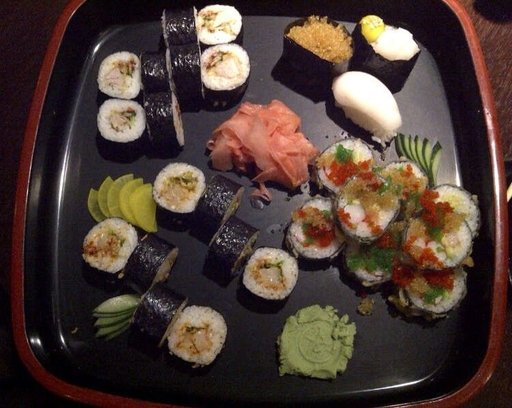

In [7]:
import random
from PIL import Image

random.seed(42)

# Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Get random iamge path
random_image_path = random.choice(image_path_list)

# Get image class from path name - the image class is the name of the directory
# where the image is stored
image_class = random_image_path.parent.stem

# Open image
img = Image.open(random_image_path)

# Print metadata
print(f"Random Image Path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

We can also use *matplotlib.pyplot.imshow()* but the only difference would be that we need to convert the image into a NumPy array first. 

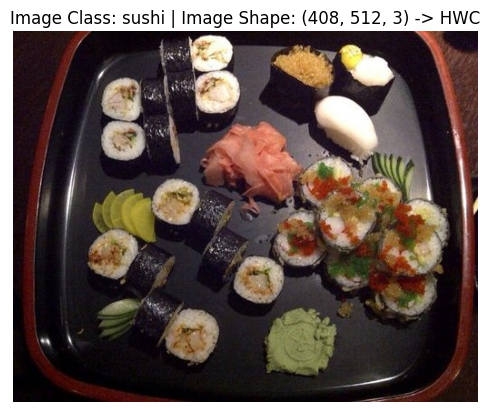

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# turning the image into a numpy array
img_as_array = np.asarray(img)

# plotting the image with matplotlib
plt.figure(figsize=(6,6))
plt.imshow(img_as_array)
plt.title(f"Image Class: {image_class} | Image Shape: {img_as_array.shape} -> HWC")
plt.axis(False);

Let's say that we wanted to load our image data into Pytorch - before we can start doing that we need to do the following:

1. Turn the image into tensors - numerical representation of the image
2. Turn it into a *torch.utils.data.Dataset* and subsequently a *torch.utils.data.DataLoader* - these are both *Dataset* and *DataLoader* for short.

There are many different kinds of pre-built datasets and dataset loaders for PyTorch and it all depends on the problem that is being worked on. 

1. Vision -> *torchvision.datasets*
2. Audio -> *torchaudio.datasets*
3. Text -> *torchtext.datasets*
4. Recommendations -> *torchrec.datasets*

Because we are working with a vision problem then it's pretty clear to see that we need to use *torchvision.datasets* for the data loading function + *torchvision.transforms* for preparing the data. 

Let's start importing the base libraries for these. 

In [9]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

**Transforming Data with *torchvision.transforms***

We have folders of images but before we can use them, we have to transform the into tensors. One way that we could do that is by using the *torchvision.transforms* module.

*torchvision.transforms* contain many prebuilt methods for formatting images, turning to tensors, and even manipulating them for **data augmentation** - the practice of altering the data to make it harder for the model to learn. 

To get some hands-on experience with *torchvision.transforms*, we can write a series of transform steps that can do the following: 

1. Resize the images using *transforms.Resize()* from about 512x512 to 64x64. The same shape as the images on the CNN Explainer website.

2. Flip the images randomly on the horizontal using *transforms.RandomHorizontalFlip()* - this can be considered as a form of data augmentation since we are artifically changing the image data.

3. Turn the images from a PIL image to a PyTorch tensor by *transforms.ToTensor()*

We can combine all these steps by using *torchvision.transforms.Compose()*

In [10]:
data_transform = transforms.Compose([
    # Resizing the images to 64x64
    transforms.Resize(size=(64,64)),
    # Flipping the images - p stands for probability of a flip
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a tensor - converts all pixel values from 0-255 to 0.0 to 1.0
    transforms.ToTensor(),
])

Because we have now built a means to transform the images based on our specifications, we can now try them on different images. Let's make a function that does exactly that.

In [11]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    # Plot a series of random images from image paths -

    # will open n image paths from image_paths then transform them
    # with transform then plot them side by side

    # Args: 
    # image_paths : list - lists of target image paths
    # transform : PyTorch Transforms - the transform specifications that would be applied
    # to all images selected
    # n : int (optional) - Number of images to be plotted - defaults to 3 
    # seed : int (optional) - Random seed for the random generator

    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            plt.figure(figsize=(10,10))
            # Showing original image
            fig, ax = plt.subplots(1,2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original Size: {f.size}")
            ax[0].axis("off")

            # Transforming & plotting image
            # permute() changes the shape of the image to suit matplotlib
            # PyTorch is CHW while matplotlib is HWC
            transformed_image = transform(f).permute(1,2,0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed Size: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=14)

<Figure size 1000x1000 with 0 Axes>

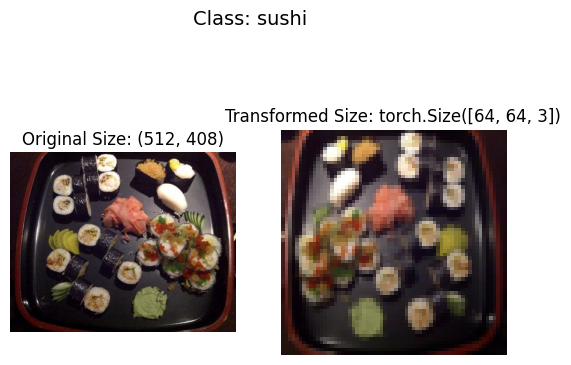

<Figure size 1000x1000 with 0 Axes>

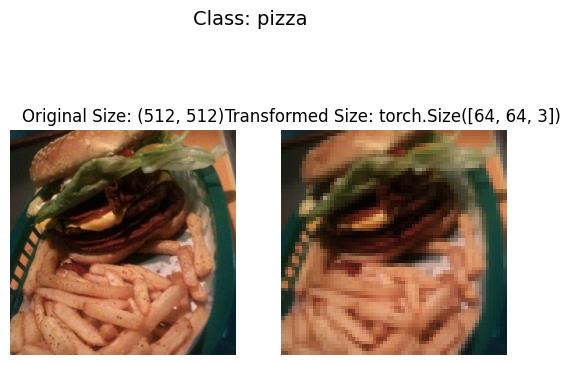

<Figure size 1000x1000 with 0 Axes>

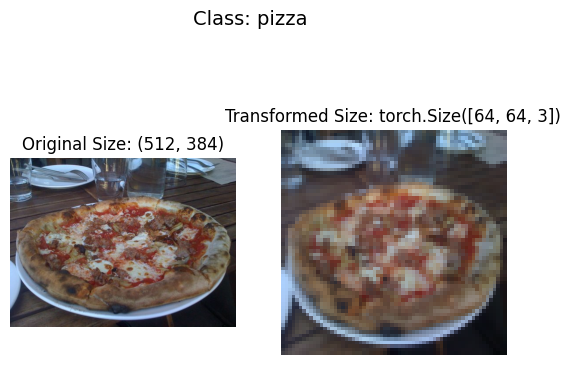

In [12]:
plot_transformed_images(image_path_list, data_transform)

We've now transformed the data that we need into PyTorch tensors with *torchvision.transforms* and at the same time we also plotted them out to visualize them! We also manipulated their size and orientation. 

it goes without saying that the larger the image means that there are more information that is retained for us to use.

For example, an image size of [256,256,3] will have 16x more pixels than an image of size [64x64x3] since 256*256*3 / 64*64*3 = 16. Simple math!

But of course, it comes at a cost. Higher resolution images and larger sizes means that there are more values to consider which means higher computational power required to use. 

If we try removing one of the transforms in *data_transform* then the outputs would change. For example, commenting out the resize would make the images retain their original size's meaning that there is no standard size for all the images. 

**Option 1 - Loading Image Data With *ImageFolder***

Since we worked out our image data with a standard size and also augmented it by transforming it with a horizontal flip on some images, we can now start turning them into a *Dataset* that can work with Python. 

Because our data is in a standard image classification format. (Don't get confused, this doesn't mean PNG, JPEG, WEBP but instead the way that the image data is organized and structured. Remember the example structure shown earlier.) 

This means that we can use *torchvision.datasets.ImageFolder*. This is a way for us to pass a file path of a target image directory alongside the series of transforms that we would like to be applied to the images in this directory.

Let's try this out on our data folders *train_dir* and *test_dir*. We'll also pass in our *data_transform* so that these images will turn it to tensors. 

In [13]:
train_data = datasets.ImageFolder(root=train_dir, # Target folder of images
                                  transform=data_transform, # Transform specifications for data (images)
                                  target_transform=None # Transform specifications for targets (labels)
                                 )

test_data = datasets.ImageFolder(test_dir, data_transform, None)
print(f"Train Data:\n{train_data} | Test Data:\n{test_data}")

Train Data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data\pizza_steak_sushi\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           ) | Test Data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data\pizza_steak_sushi\test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


That's a lot of valuable info that we are able to get from these datasets! Seems like PyTorch has recognized these and have made them into *Dataset* classes. Let's check them out by using PyTorch functions on them such as *classes* and *class_to_idx* attributes. At the same time, we'll also take a look at the lengths of each dataset. 

In [14]:
# Grabbing class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [15]:
# Grabbing class names as a dictionary
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [16]:
# Checking out length of each dataset
len(train_data), len(test_data)

(225, 75)

Great! We can really use these functions as means to learn more about our datasets and also use them as references if we need them in the near future. But, let's go deeper and take a look at the data itself inside the datasets. We'll index *train_data* and *test_data* to pick off samples and their associated labels.

In [17]:
# We are indexing an image on the first index then we get the data / label on the second index
img, label = train_data[0][0], train_data[0][1]
print(f"Image Tensor: \n{img}")
print(f"Image Shape: {img.shape}")
print(f"Image Datatype: {img.dtype}")
print(f"Image Label: {label}")
print(f"Label Datatype: {type(label)}")

Image Tensor: 
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

From the information provided, we can tell that the shape of our images are in [3,64,64] - color_channels, height, width. The label is also an integer that is referring to the associated index of the label class. So, if we recall our *class_names* then we would see that this image is a pizza. 

Let's try this using matplotlib. Of course, since this is a PyTorch tensor, we'll have to permute this into a NumPy array. Because the dimensions of PyTorch is formatted to CHW and NumPy is HWC. 

In [18]:
img_permuted = img.permute(1,2,0)
# Printing the shapes before and after permutation
print(f"Image PyTorch Tensor Dimenshion Shape: {img.shape} | Format: CHW")
print(f"Image NumPY Array Dimension shaoe: {img_permuted.shape} | Format: HWC")

Image PyTorch Tensor Dimenshion Shape: torch.Size([3, 64, 64]) | Format: CHW
Image NumPY Array Dimension shaoe: torch.Size([64, 64, 3]) | Format: HWC


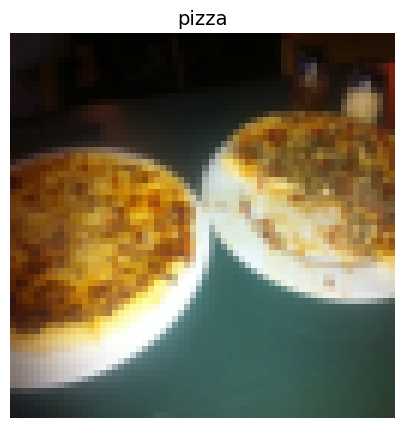

In [19]:
# Plotting image
plt.figure(figsize=(5,5))
plt.imshow(img_permuted)
plt.axis("off")
plt.title(class_names[label], fontsize=14);

We can see that the image is a lot more pixelated! It's because we downscaled the image from it's original size to our intended size of 64x64 through our *data_transform*. Basically, it's a pretty simple concept. If you find the image hard to recognize then chances are the model itself will also have a hard time doing the same. 

**Turning Loaded Images To *DataLoader***

Since we have made our data compatible with PyTorch by making them into *dataset* objects, we can now start turning them into *DataLoaders*. We'll do this using *torch.utils.data.DataLoader*

Remember that *Dataset* objects are turned into *DataLoader* objects because that allows us to make them iterable (batching) so a model can start learning the relationships between the samples and targets (features - labels).

We'll keep things simple by putting our *batchsize=1* and *num_workers=1*. You might be wondering, what's *num_workers*?. It defines how many subprocesses will be created to load your data. 

Bit confusing? Think of it like this, the higher value we give to *num_workers* means that PyTorch will increase the compute power needed to load the data. This is more related to the processor side and moving data around. We're not dealing with a large number of data so it'll be all fine. In anycase, you can just set it to the number of cores you have on your processor.

We can figure the amount of CPUs we have by *os.cpu_count()*. This just means that we are grabbing all the cores we have to load the data. 

In [20]:
# Checking how many cores we have on our device
os.cpu_count()

12

In [21]:
# Turning train_data and test_data into DataLoaders
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=1, # How many saplers per batch
    num_workers=os.cpu_count(), # How many cpu's to allocate for loading data
    shuffle=True # Usually, it's best to shuffle train data
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=1,
    num_workers=os.cpu_count(),
    shuffle=False # Usually, there's no reason to shuffle test data
)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x18dd5ab3080>,
 <torch.utils.data.dataloader.DataLoader at 0x18dd48c52e0>)

We're done with turning our *Datasets* into *DataLoaders*. They are now iterable! Let's take a look at their shapes. 

In [22]:
# Isn't a DataLoader iterable? Yes! It is, but we create ANOTHER iterator per batch so that we can grab a single data/label from one batch.
# If we do next(train_dataloader) then we get the ENTIRE batch's data/label. We just want one.
img, label = next(iter(train_dataloader))
print(f"Image Shape {img.shape} -> batch_size, color_channels, height, width")
print(f"Label Shape {label.shape}")

Image Shape torch.Size([1, 3, 64, 64]) -> batch_size, color_channels, height, width
Label Shape torch.Size([1])


With our *DataLoader*'s ready to use, we can now make a training/testing loop to train a model. So, our data is ready! But, let's play around more with it and take a look at an another option that we can use to load images (or any other data that we want).

**Option 2: Loading Image Data With Custom *Dataset***

We've relied on a pre-built *Dataset* creator before. But what if we didn't have the option to use *torchvision.datasets.ImageFolder()*? Are we out of options? Nope. We can build our own. 

But what's the difference? Is there any benefit in making a custom way to load *Dataset*'s? Let's take a look:

1. **Pros of creating a custom dataset**: Can create a *dataset* object from almost anything and it's not limited to PyTorch pre-built *Dataset* functions. Basically, more freedom and flexibility.

2. **Cons of creating a custom dataset**: No guarantee that your custom *Dataset* would work. Because we're making it from scratch then that means you are putting more effort and time in writing code, troubleshooting, and probably even dealing with performance issues.

It's a lot better to do this in practice. Let's replicate how *torchvision.datasets.ImageFolder()* works by subclassing *torch.utils.data.Dataset* - the base class for all *Dataset*'s in PyTorch. 

Before getting started, we'll need to import the moduels:

1. Python's *os* to work with directories.
2. Python's *pathlib* to work with filepaths.
3. *torch* (self-explanatory).
4. PIL's *Image* class for viewing images.
5. *torch.utils.data.Dataset* for subclassing and creating our own custom *Dataset*.
6. *torchvision.transforms* for turning images into tensors.
7. External types from Python's *typing* module to add type hints to our code.

These steps aren't set in stone. You can customize them depending on the dataset that you are working with. At the end of the day, it's all about writing code to load your data into the format that you need it to be. 

In [23]:
import os
import pathlib
import torch

from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
from typing import Tuple, Dict, List

Remember that our *Dataset* instances before had access to functions such as *torchvision.datasets.ImageFolder()* which gave the capability to use the *classes* and *class_to_idx* attributes? 

In [24]:
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

**5.1 Creating Helper Functions To Get Class Names**

We'll have to do that manually ourselves. So, we'll start by creating a helper function that can create a list of class names + a dictionary of class names and their indexes based on their directory paths. 

Let's list this task to make it a lot easier to visualize:

1. Grabbing the class names with *os.scandir()* to traverse a target directory - ideally, the directory is in the same standard image classification format to make it easier.

2. Raise an error if the class names aren't found when scanning the directories, in the case that this happens then that means there is something wrong with the directory structure.

3. Turn the class names into a dictionary of numerical labels - one for each class.

Let's observe how it works with step 1 before writing everything in one go.

In [25]:
image_path

WindowsPath('data/pizza_steak_sushi')

In [26]:
# Setting up path for target directory
target_directory = train_dir
print(f"Target Directory : {target_directory}")
print(f"Image Path: {image_path}")
# Grabbing the class names from the directories inside the target directory
class_names_detected = sorted([entry.name for entry in list(os.scandir(image_path/"train"))])
print(f"Class Names Detected: {class_names_detected}")

Target Directory : data\pizza_steak_sushi\train
Image Path: data\pizza_steak_sushi
Class Names Detected: ['pizza', 'steak', 'sushi']


In [27]:
# Creates a generator expression which outputs a list thanks to sorted - strict
generator_exp = sorted(entry.name for entry in os.scandir(image_path/"train") if entry.is_dir())
# Similiar with the first one but does not check if entry is a directory - less strict
gen_exp_without_checks = sorted(entry.name for entry in os.scandir(image_path/"train"))
# Uses list comprehension, guarantees an output of a list, does not check if entry is a directory
list_comprehension = sorted([entry.name for entry in list(os.scandir(image_path/"train"))])
# All share a similiar output, just different methods of doing the same thing

In [28]:
# Returns an iterator of os.DirEntry objects
scandir = os.scandir(image_path/"train")
print(f"Scandir Iterator: {scandir}")
# Turns iterator into a list of os.DirEntry objects
listedDir = list(scandir)
print(f"List of DirEntry Objects: {listedDir}")
# Specifies the name of one os.DirEntry object
print(f"Name of one DirEntry Object: {listedDir[0].name}")

Scandir Iterator: <nt.ScandirIterator object at 0x0000018DCC851750>
List of DirEntry Objects: [<DirEntry 'pizza'>, <DirEntry 'steak'>, <DirEntry 'sushi'>]
Name of one DirEntry Object: pizza


Looks like everything is working as intended. So let's try making this into a full function that we can use. 

In [29]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    # Finds the class names in the target directory
    # Takes a directory string as an input
    # Outputs a tuple of a list of strings or a tuple of a dictionary containing a string and an int
    # Example: find_classes("food_images/train")
    # Output: (["class_1", "class_2", ...] OR {"class_1": 0, ...})

    # 1. - Get class names - This uses a generator expression meaning that it checks if a entry is a directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # 2. Raise error if no classes found  
    if not classes:
     raise FileNotFoundError(f"No Classes Found at {directory}!")

    # 3. Turn class names into a dictionary of numerical labels - computers prefer numerical labels over string labels
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
    return classes, class_to_idx

In [30]:
# We are changing a list into a dictionary with enumerate. In addition we are using a list comprehension that takes the class_names from the
# list and uses that as a the first element in the new dictionary, followed by an index that increments per class_name found in enumerate
generator_exp = sorted(entry.name for entry in os.scandir(image_path/"train") if entry.is_dir())
class_to_idx = {class_name: i for i, class_name in enumerate(generator_exp)}
class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

Now that we're done talking about some basic Python syntax and explanations, it's time to test our helper function! 

In [31]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

**Creating Custom *Dataset* For Replicating *ImageFolder***

Let's start working on our own custom *Dataset*. So we're going to rebuild the functionalities of *torchvision.datasets.ImageFolder()* from scratch. This is a good way of removing the mystery around *ImageFolder()* and at the same time is good practice for making your own custom *Dataset*. It'll be a lot of code to work with but that's always a good thing! 

As always, let's break it down into steps:

1. So starting of we'll subclass *torch.utils.data.Dataset*.
2. We make our subclass with a *targ_dir* parameter (the target data directory) and *transform* parameter so that we have the option to transform the data if we need to.
3. Create several attributes for *paths* (the paths of our target images), *transform* (the transforms that we would like to use - this can be *None*), *classes* and *class_to_idx*
4. Create a function to load mages from file and return them, this could be using *PIL* or *torchvision.io* - for input/output of vision data.
5. Overwite the *__len__* method of *torch.utils.data.Dataset* to return the number of samples in the *Dataset*, this is recommended but not required. This allows you to do the *len(Dataset)*.
6. Overwrite the *__getitem__* method of *torch.utils.data.Dataset* to return a single sample from the *Dataset*, this is required.

Let's start working on it: 

In [32]:
# 1. Subclassing torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    # 2. Initialize with targ_dir and transform (optional) parameters 
    def __init__(self, targ_dir: str, transform=None) -> None:
        # 3. Create class attrivutes
        # Get all image paths 
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) # This needs to be changed depending on the file format of the image
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via path and returns image"
        image_path = self.paths[index]
        return Image.open(image_path)

    # 5. Overwrites the __len__() method - optional but recommended for subclasses of torch.utils.data.Dataset
    def __len__(self) -> int:
        return len(self.paths)

    # 6. Overwrites the __get__item() method - required for subclasses of torch.utils.data.Dataset
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        # This returns one sample with data and target
        img = self.load_image(index)
        class_name = self.paths[index].parent.name # We get the parent folder's name since that contains the image's class. 
        class_idx = self.class_to_idx[class_name] # We transform the class name to a dictionary

        # Allows transformation if needed
        if self.transform:
            return self.transform(img), class_idx # returns data, label (X,y)
        else:
            return img, class_idx # returns data, label (X,y

In [33]:
# Visualization of how the paths codeblock work: Returns a list of all the paths for each image in the train dataset
paths = list(pathlib.Path(image_path/"train").glob("*/*.jpg"))
print(f"Paths:{paths[:5]}")
# Visualization of how the overwritten __len__() method works
print(f"Length of Paths: {len(paths)}")

Paths:[WindowsPath('data/pizza_steak_sushi/train/pizza/1008844.jpg'), WindowsPath('data/pizza_steak_sushi/train/pizza/1033251.jpg'), WindowsPath('data/pizza_steak_sushi/train/pizza/1044789.jpg'), WindowsPath('data/pizza_steak_sushi/train/pizza/1089334.jpg'), WindowsPath('data/pizza_steak_sushi/train/pizza/1105700.jpg')]
Length of Paths: 225


That's quite a long block of code alongside some curious means of implementation. Show's the downside of creating your own custom *Dataset* when you can make this in just one line of code if we'd just used *ImageFolder()*. Once we've written it tho, there's not much to worry about. We can move it into a *.py* file such as *data_loader.py* alongside with other helpful data functions which we can reuse later on.

Before we can actually test our new *ImageFolderCustom* class, we'll need to create some transforms to prep the images for use.

In [34]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor()
])

# No reason to augment test data
test_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

It's time to see if everything is working as they should be! We'll be turning our training images contained in *train_dir* and our testing images contained *test_dir* into *Dataset*'s using our own custom-built *ImageFolderCustom* class. 

In [35]:
train_data_custom = ImageFolderCustom(
    targ_dir=train_dir,
    transform=train_transforms
)

test_data_custom = ImageFolderCustom(
    targ_dir=test_dir,
    transform=test_transforms
)

train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x18dd5d7d700>,
 <__main__.ImageFolderCustom at 0x18dd5d01bb0>)

At the very least, we have no errors! So that's good? Did it work? Let's try out the functions that we have overwritten. Let's start with *len()* on our new *Dataset* and then we'll find the *classes* and *class_to_idx* attributes.  

In [36]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [37]:
train_data_custom.classes, test_data_custom.classes

(['pizza', 'steak', 'sushi'], ['pizza', 'steak', 'sushi'])

In [38]:
train_data_custom.class_to_idx, test_data_custom.class_to_idx

({'pizza': 0, 'steak': 1, 'sushi': 2}, {'pizza': 0, 'steak': 1, 'sushi': 2})

Seems like everything is in order, let's try comparing it to the *ImageFolder()* class. We can check for equality just by doing == 

In [39]:
# Check for equality amongst our Custom Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True


3 out of 3 checks! Seems like we're on the right track. We've still got one thing that we haven't tested from our custom *Dataset* and that is the __getitem__ override that we specified. 

**Creating Function For Displaying Random Images**

It's time to visualize!!!

We'll be creating another helper function called *display_random_immage* which will help us visualize the images in our *Datasets*'s. 

Specifically it will do the following:

1. Take in a *Dataset* alongisde a number of other parameters such as *classes* - the number of targets that we have for our *Dataset*, the number of images that we want to display *n* and a random seed to use.

2. In order that we won't go crazy with the number of images that we can display, we'll hardcap *n* to just 10 images.

3. We'll also set an arbitrary number for the *seed* so that we can reproduce the plot.

4. Get a list of random sample indexes by using Python's *random_sample()* function for plotting.

5. Setting up a *matplotlib* plot.

6. Loop through the random sample indexes and start plotting them with *matplotlib*.

7. Permute the sample images so that they are transformed from CHW to HWC so that plotting could be done 

In [40]:
# 1. Taking Dataset in list of class names
def display_random_image(dataset: torch.utils.data.dataset.Dataset,
                        classes: List[str] = None,
                        n: int = 10,
                        display_shape: bool = True,
                        seed: int = None):

    # 2. Ensuring that n is always below 10
    if n > 10:
        n = 10
        display_shape = False
        print(f"Limited to a maximum of 10 images for display")

    # 3. Seed number
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_sample_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16,8))

    # 6. Looping through samples and displaying random idx images
    for i, targ_sample in enumerate(random_sample_idx):
        targ_img, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor for plotting: permuting from CHW to HWC 
        target_image_adj = targ_img.permute(1,2,0)

        # 8. Plotting adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(target_image_adj)
        plt.axis("off")
        if classes:
            title = f"Class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nShape: {target_image_adj.shape}"
        plt.title(title)

No errors and everything seems to be good. Let's try it out and actually use this function. First, let's use the *train_data* from *ImageFolder* rather than our own custom dataset.

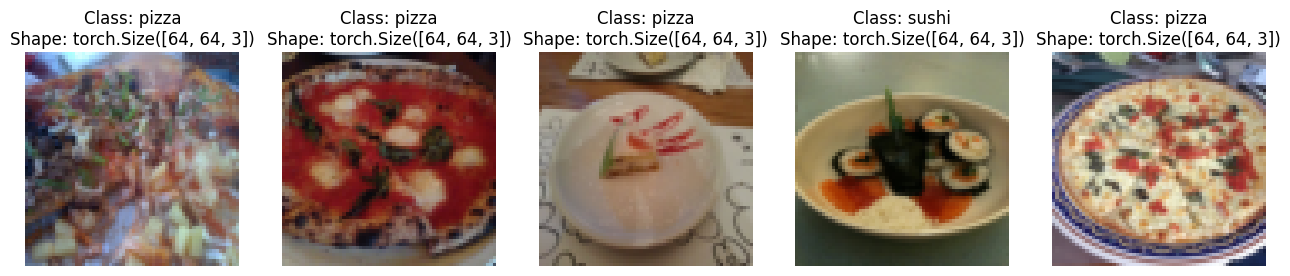

In [41]:
# Displaying random images from ImageFolder created Dataset
display_random_image(dataset=train_data, n=5, classes=class_names, seed=None)

Looks fine! How about our custom *dataset*? Let's try it out.

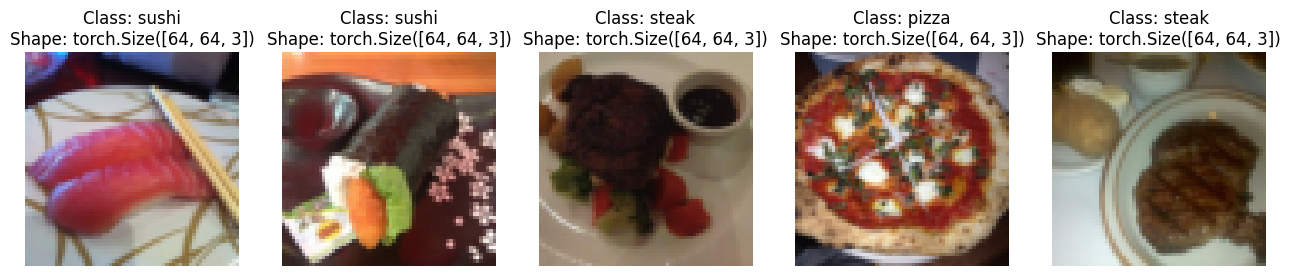

In [42]:
# Displaying random images from ImageFolder created Dataset
display_random_image(dataset=train_data_custom, n=5, classes=class_names, seed=None)

We've successfully recreated the *ImageFolder* function and have implemented our own custom *dataset*. Let's try working on loading our custom images into *DataLoader*.

**Turning Custom Loaded Images Into *DataLoader***

We've made our images into *Datasets* (features mapped to labels or *X* mapped to *y* with PyTorch's *ImageFolder()* and our own custom-built *ImageFolderCustom*) but how do we turn these into *DataLoader*'s? Is the process the same as with using PyTorch's built-in *ImageFolder()* class? 

Turns out, it's exactly the same! We can still work with using *torch.utils.data.DataLoader()* simply because our custom *Dataset* is subclassed to *torch.utils.data.Dataset*. Meaning that these two can still work together. 

In [43]:
train_dataloader_custom = DataLoader(
    dataset=train_data_custom,
    batch_size=1,
    num_workers=0,
    shuffle=True
)

test_dataloader_custom = DataLoader(
    dataset=test_data_custom,
    batch_size=1,
    num_workers=0,
    shuffle=False
)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x18dd8851010>,
 <torch.utils.data.dataloader.DataLoader at 0x18dd8892360>)

Let's take a look at the shape of the images in the DataLoader. Let's see if they're still the same

In [44]:
img_custom, label_custom = next(iter(train_dataloader_custom))

print(f"Image Shape: {img_custom.shape} - batch_size, color_channels, height, width")
print(f"Label Shape: {label_custom.shape}")

Image Shape: torch.Size([1, 3, 64, 64]) - batch_size, color_channels, height, width
Label Shape: torch.Size([1])


Still the same as before. This means that we've done everything correctly.

**Other Data Transformations - Data Augmentation**

We've already worked with data transformations in the form of HorizontalFlipping earlier but there's plenty of other ways that we can transform our data. We can take a look at PyTorch's *torchvision.transforms* documentation. 

Again, data augmentation and transforms are done to alter the images in a certain way. This even includes turning images into tensors. 

But aside from that, you can probably guess what else is possible from rotating, scaling, cropping, or even randomly removing portions of an image. These kinds of transforms are referred to as *data augmentation*.

To put it in a more formal definition. *Data augmentation* is a process of altering data in a way that you can artificially increase the diversity of a dataset. So this helps a lot when you are dealing with a small number of data because you can increase the amount without having to find new data, just reusing the current one's by transforming them.

This is done because it is hoped that a model can perform better when it comes to generalizing patterns. 

Let's try one.

One of the more interesting things about machine learning is that it greatly benefits from randomness. Transforms that use randomness have been shown to perform better as compared to hand-picked transforms. Examples of transforms that utilize randomess is *transforms.RandAugment()* and *transforms.TrivialAugmentWide()*.

TrivialAugment is pretty... simple. Basically, you have a set of transforms - translation, cropping, rotation, etc. which are randomly chosen for each image. Then these transformations are also randomly scaled. So you have two random things happening. The transform and the intensity of that transformation. 

So, why not use it on our own images? 

The only parameter that we should take into consideration when using *transforms.TrivialAugmentWide()* is *num_magnitude_bins*. This parameter involves affecting the maximum intensity of each transform being applied. So starting with 0 meaning there's no range and 31 being the maximum range - highest chance for highest intensity.

What if it's 0? That just means that the transforms are applied with the most minimal of intensities / or no transforms will be applied at all. Basically, it's just gonna make the entire thing negligable. 

We can call *transforms.TrivialAugmentWide()* in *transforms.Compose()*

In [45]:
train_augment_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor(),
])

# No reason to apply data augmentation on test set
test_augment_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

So, there's no reason for you to diversify your test set. The reason that we do data augmentation is so that our train data can be get larger thus helping our training for the model. We're not training our model with the test set so there's no reason to augment it. 

However, we need to make sure that our images are standardized to a similiar size for their shapes. Inference can be applied to images that don't match with sizes but this will affect performance. It's best to just make everything the same size so that it's a lot easier overall.

Now that we have our data augmentation setup, let's start working with it. 

<Figure size 1000x1000 with 0 Axes>

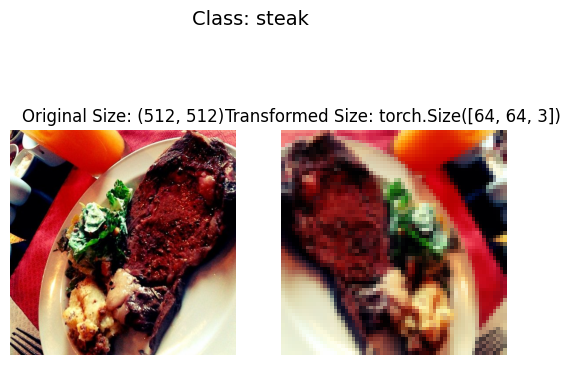

<Figure size 1000x1000 with 0 Axes>

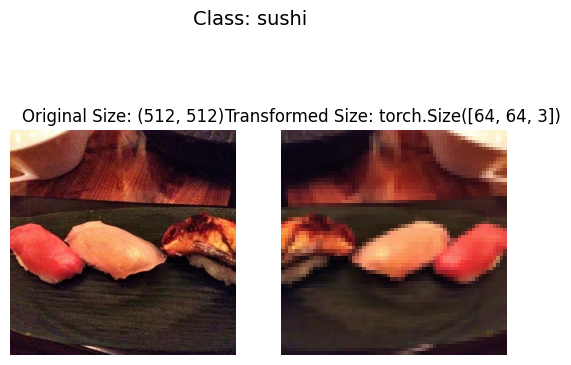

<Figure size 1000x1000 with 0 Axes>

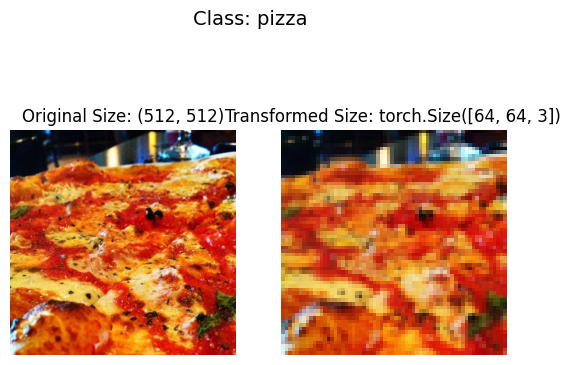

In [46]:
image_path_list = list(image_path.glob("*/*/*.jpg"))
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=None
)

We can rerun the cell to see different transforms and intensities being performed on *train_data*. 

**Baseline / Model 0 : TinyVGG Without Data Augmentation**

Because we're done tinkerin with our data, it's time to start building our very first baseline model. To start everything off, we'll keep it simple with the transform just being a simple resize of the shape (64, 64) and turning the images into tensors. 

**Creating Transforms & Loading Data For Baseline / Model 0**

In [47]:
simple_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
])

Now that we have our simple transform of resizing and switching to tensors, we can do the following:
1. Load the data, turning both training and testing folders into *Dataset* using *torchvision.datasets.ImageFolder()*
   
2. Turn the *Dataset*'s into *DataLoader* with *torch.utils.data.DataLoader*. batch_size will be set at 32 & num_workers will be subjective - best to be set at the number of CPUs on the device that you have. 

In [48]:
# Create Datasets with associated transforms
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

# Set specificed parameter variables
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Turn Datasets into DataLoaders
train_dataloader_simple = DataLoader(dataset=train_data_simple, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
test_dataloader_simple = DataLoader(dataset=test_data_simple, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)

train_dataloader_simple, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x18dd9187590>,
 <torch.utils.data.dataloader.DataLoader at 0x18dd8efd580>)

With the *DataLoader*'s done, we can start working on the model that we want to make.

**Creating TinyVGG Model Class**

The TinyVGG Model is a model that is similiar to the structure from the CNN-Explainer Website. So, we'll be creating the same model for our baseline but instead of working with gray-scaled images, we'll be working with RGB so the *in_channels* will start with 3 for each color channel as opposed to just 1. 

In [49]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units,
                      kernel_size=3, # How big is a square - 3 means 3x3
                      stride=1, # Default
                      padding=1 
                     ),
            nn.ReLU())
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # Default stride value is same as kernel_size
        )
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, 1, 1),
            nn.ReLU()
        )
        self.conv_block_4 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Goes through MaxPooling of 2 twice - meaning it downscales the image
            # by size of 2 meaning 64 - 32 - 16.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape
                     )
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.conv_block_4(x)
        x = self.classifier(x)
        return x 

In [50]:
# Instantiating a model 
baseline_model = TinyVGG(3, 10, len(train_data.classes)).to(device)
baseline_model

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_3): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv_block_4): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

There is actually one pretty simple optimization that we can use to speed up deep learning model's computing on GPUs. That's by using *operator fusion*.

In a nutshell, when we define forward() - we just call all the blocks together. We skip reassigning x and just instead directly call the next block to the next and etc. 

For example, assume that we only have two convolution blocks as opposed to the four that we made our TinyVGG model with- our forward would be akin to this:

*return self.classifier(self.conv_block_2(self.conv_block_1(x)))*

The reason as to why this makes everything faster is because we aren't spending memory anymore with reassigning *x* but instead we just focus on computing *x*.

Let's try doing a forward pass on a single image through our baseline model and see how everything looks.

**Trying a Forward Pass on a Single Image (Testing Model)**

One good way to test out a model without having to go through the entire trouble of the usual training and testing is to just do a forward pass on a single piece of data.

This way we can check the input/outputshapes of the different layers. So, starting off  with the steps to take to do this:

1. Get a batch of images/labels from *DataLoader*
   
2. Get a single image/label from the batch and make sure that the image shape can fit in the model. Remember that the model must take a shape of *batch_size, color_channels, height, width*. 
   
3. Do inference/forward pass on the image. Make sure that the image is on the same device as the model.
   
4. Convert the logits into prediction probabilities with *torch.softmax()* then turn these probabilities into prediction labels with *torch.argmax()*

In [51]:
# Take image from DataLoader
image = next(iter(train_dataloader))
image_data, image_label = image[0], image[1]
print(f"Image Shape: {image_data.shape}")
print(f"Label Shape: {image_label.shape}")

baseline_model.eval()
with torch.inference_mode():
    logits = baseline_model(image_data.to(device))

print(f"Logits: {logits}")
print(f"Logits Shape: {logits.shape}")
print(f"Prediction Probs: {torch.softmax(logits, dim=1)}")
print(f"Prediction Label: {torch.argmax(torch.softmax(logits, dim=1), dim=1)}")
print(f"Actual Label: {image_label}")

Image Shape: torch.Size([1, 3, 64, 64])
Label Shape: torch.Size([1])
Logits: tensor([[ 0.0064,  0.0093, -0.0043]], device='cuda:0')
Logits Shape: torch.Size([1, 3])
Prediction Probs: tensor([[0.3342, 0.3352, 0.3306]], device='cuda:0')
Prediction Label: tensor([1], device='cuda:0')
Actual Label: tensor([1])


Looks good! Of course, our model isn't even trained yet so the predicitons are just entirely random. The more important thing is that we can see that everything else seems to work as they are intended. 

Now, let's take at a new info gathering function that we can use to help us in knowing more about our model. Just like how we can do *print(model)* to know more about a model's structure. 

**Using *torchinfo* To Identify Shapes Going Through The Model**

One more way that we can get more info about our model is using *torchinfo*. This provides us a method called *summary()* which takes a PyTorch model and an *input_shape* and then returns a detailed look on what happens when a tensor moves along through the model. 

Let's try it out

In [52]:
pip list

Package                   VersionNote: you may need to restart the kernel to use updated packages.

------------------------- --------------
anyio                     4.3.0
argon2-cffi               23.1.0
argon2-cffi-bindings      21.2.0
arrow                     1.3.0
asttokens                 2.4.1
async-lru                 2.0.4
attrs                     23.2.0
Babel                     2.14.0
beautifulsoup4            4.12.3
bleach                    6.1.0
certifi                   2024.2.2
cffi                      1.16.0
charset-normalizer        3.3.2
colorama                  0.4.6
comm                      0.2.2
contourpy                 1.2.1
cycler                    0.12.1
debugpy                   1.8.1
decorator                 5.1.1
defusedxml                0.7.1
distlib                   0.3.8
executing                 2.0.1
fastjsonschema            2.19.1
filelock                  3.13.4
fonttools                 4.51.0
fqdn                      1.5.1
fsspec        

In [53]:
from torchinfo import summary
summary(model=baseline_model, input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 64, 64]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
├─Sequential: 1-2                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-3                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
├─Sequential: 1-4                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU

This is an absolute treasure trove of information that we can use to learn more about our model and how the tensors change when passing through each layer.

We get items such as *total params* which provide us the total number of parameters in the model. As well as the total size of the model itself. 

More importantly, we get to see how the shape changes as it goes through the layers. As of now, the number of parameters and even the size of the model is pretty low. That's because we are working with a small model.

We always have the option to go big later on.

**Creating Train & Test Loop Functions**

Since we have the data and the model ready, it's time to work on creating our train and test loop functions. It's a lot better to just make them as functions and call them later on so that we don't have to keep rewriting things. 

We're going to make three functions:
1. *train_step()* - This takes in a model, a *DataLoader*, loss function, an optimizer, accuracy function, and device. Then the function trains the model on the *DataLoader*.

2. *test_step()* - This takes in a model, a *DataLoader*, loss function, accuracy function and device. Then the function evaluates the model with the *DataLoader*.

3. *train()* - This is takes both of the previous two and combines them together ine one. It performs for a given number of epochs and then returns a dictionary of results.

We start with making *train_step()*. Remember, we're working with batches in the *DataLoader*'s so we'll first need to accumuluate the loss and accuracy values during training and then adjust them at the end just before returning them.

In [54]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               optim: torch.optim.Optimizer,
               device: torch.device = device
               ):
    # Putting model to train
    model.train()
    # Setting up loss & acc variables
    train_loss, train_acc = 0,0
    # Looping through DataLoader in batches
    for batch, (X,y) in enumerate(dataloader):
        # Send data to target device
        X,y = X.to(device), y.to(device)
        # Forward pass
        y_pred = model(X)
        # Calculate loss & acc
        loss = loss_fn(y_pred, y)
        acc = accuracy_fn(y, y_pred.argmax(dim=1))
        # Step the loss & acc of the batch to global train_loss & train_acc
        train_loss += loss.item()
        train_acc += acc.item()
        # Reset weights to zero 
        optim.zero_grad()
        # Backpropagation
        loss.backward()
        # Step weights
        optim.step()

    # Divide the total variables with the number of batches in DataLoader
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [55]:
def test_step(model: torch.nn.Module,
             dataloader: torch.utils.data.DataLoader,
             loss_fn: torch.nn.Module,
             accuracy_fn,
             device: torch.device = device):
    # Putting model to eval
    model.eval()
    # Setting up loss & acc variables
    test_loss, test_acc = 0,0
    with torch.inference_mode():
        for batch, (X,y) in enumerate(dataloader):
            # Send data to target device
            X,y = X.to(device), y.to(device)
            # Forward pass
            y_pred = model(X)
            # Calculate loss & acc
            loss = loss_fn(y_pred, y)
            acc = accuracy_fn(y, y_pred.argmax(dim=1))
            # Step the loss & acc of the batch to global train_loss & train_acc
            test_loss += loss.item()
            test_acc += acc.item()

    # Divide the total variables with the number of batches in DataLoader
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

**Creating a *train()* Function to Combine *train_step()* and *test_step()***

To make it even more easier, we'll be combining these two functions together into one with *train()*. This function will train & test the model. 

Specifically it will do the following:

1. Take a model, *Dataloader*'s for training and testing sets, an optimizer, a loss function, an accuracy function, and how many epochs will be done on the train and test step.

2. It will create an empty results dictionary for *train_loss*, *train_acc*, *test_loss*, and *test_acc* values.

3. Loop through the training and testing step functions for the specified number of epochs.

4. Printing outputs per end of an epoch.

5. Update the empty results dictionary with the updated metrics for each epoch.

6. Return the filled dictionary.

In order to properly track the number of epochs that we've run through, we'll be importing *tqdm* from *tqdm.auto*. This is one of the more popular libraries used to get a progress bar for Python and at the same time, *tqdm.auto* automatically chooses what kind of progress bar is best depending on the computing environment. 

For example, it will automatically detect if you are using a Jupyter Notebook or a Python script.

In [56]:
# Getting all required parameters for training & test steps
def train(model: torch.nn.Module,
         train_dataloader: torch.utils.data.DataLoader,
         test_dataloader: torch.utils.data.DataLoader,
         loss_fn: torch.nn.Module,
         accuracy_fn,
         optimizer: torch.optim.Optimizer,
         epochs: int):

    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
              }

    # Loop through the train & test steps for a specifc number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model, 
                                           train_dataloader, 
                                           loss_fn, 
                                           accuracy_fn, 
                                           optimizer)
        test_loss, test_acc = test_step(model,
                                       test_dataloader,
                                       loss_fn,
                                       accuracy_fn)
        
        # Print what is happening in an epoch
        print(
            f"Epoch: {epoch+1} | "
            f"Train Loss: {train_loss:.4f} | "
            f"Train Accuracy: {train_acc:.4f} | "
            f"Test Loss: {test_loss:.4f} | "
            f"Test Accuracy: {test_acc:.4f}"
        )
        
        # Updating results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return filled results at the end of the epoch
    return results

**Train & Evaluate Baseline Model**

We've built all the functions that we need to start training and testing our model. 

Let's put our baseline model, *DataLoader*'s and *train()* functions together and see if everything is working as intended. Checking to see if these three can output a result that can identify a pizza, steak, and sushi apart. 

Just to make things quicker, we'll train for 5 *epochs*. The loss function would be *torch.nn.CrossEntropyLoss()* and we'll be switching up the optimizer that we are going to use. From *torch.optim.SGD()* to *torch.optim.Adam()*. The learning arte would be *1e-3*.

At the same time, we'll be importing Python's *timeit.default_timer()* method to calculate the training time.

We'll be instantiate the model again just so that everything is a lot cleaner. 

In [57]:
baseline_model = TinyVGG(input_shape=3, 
                         hidden_units=10, 
                         output_shape=len(train_data.classes)).to(device)
baseline_model

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_3): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv_block_4): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [58]:
loss_fn = nn.CrossEntropyLoss()
accuracy_fn = torchmetrics.Accuracy(task='multiclass', num_classes=len(class_names)).to(device)
optimizer = torch.optim.Adam(baseline_model.parameters(), lr=0.001)

In [59]:
# Setting random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Number of epochs
NUM_EPOCHS = 5

# Starting timer
start_time = timer()

# Train model - we aren't using data augmentation so the dataloader should be
# the one with the simple transforms only
model_0_results = train(model=baseline_model,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        loss_fn=loss_fn,
                        accuracy_fn=accuracy_fn,
                        optimizer=optimizer,
                        epochs=NUM_EPOCHS
                       )

# Stopping timer
end_time = timer()
print(f"Total Training Time: {end_time - start_time:.3f} Seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Train Loss: 1.1053 | Train Accuracy: 0.2500 | Test Loss: 1.0994 | Test Accuracy: 0.2604
Epoch: 2 | Train Loss: 1.0888 | Train Accuracy: 0.4258 | Test Loss: 1.1127 | Test Accuracy: 0.2604
Epoch: 3 | Train Loss: 1.0804 | Train Accuracy: 0.4258 | Test Loss: 1.1387 | Test Accuracy: 0.2604
Epoch: 4 | Train Loss: 1.1148 | Train Accuracy: 0.3047 | Test Loss: 1.1403 | Test Accuracy: 0.2604
Epoch: 5 | Train Loss: 1.0872 | Train Accuracy: 0.4258 | Test Loss: 1.1256 | Test Accuracy: 0.2604
Total Training Time: 109.635 Seconds


That looks ... pretty bad! The loss is high and the accuracy is low with no improvements being done in between the epochs. The results are the same for both the train and test sets. 

But that doesn't mean we should give up. Let's keep going. Maybe there are ways that we can do to improve the results? Adding more layers, increasing the hidden units, changing the learning rate, trying out different loss or actication functions, more epochs?

**Plotting Loss Curves of Baseline Model**

The printing of the outputs do give us an idea that our model wasn't performing as well as we had hoped but that's not a lot of info. There's a way that we can further evaluate the model by plotting the *loss curves*.

*Loss curves* showcase the results of the model over time. They can be a great way to visualize all the numbers that you're looking at. In addition, you can easily see the differences in performances between train and test sets. 

With that said, let's make a function to plot the values of the *model_0_results* dictionary.

In [60]:
# Checking the keys in the dictionary
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [61]:
model_0_results['train_loss']

[1.1053148061037064,
 1.0887529850006104,
 1.0804281383752823,
 1.1148114651441574,
 1.0871514230966568]

In [62]:
# Plots training/testing curves of a results dictionary
def plot_loss_curves(results: Dict[str, List[float]]):
    
    # Get loss values of the results - train & test
    train_loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results - train & test
    train_acc = results["train_acc"]
    test_acc = results["test_acc"]

    # Get the number of epochs
    epochs = range(len(results['train_loss']))

    # Setting up a plot
    plt.figure(figsize=(15,7))

    # Plotting loss
    plt.subplot(1,2,1)
    plt.plot(epochs, train_loss, label="Train Loss")
    plt.plot(epochs, test_loss, label="Test Loss")
    plt.title("Loss")
    plt.legend()

    # Plotting accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, train_acc, label="Train Accuracy")
    plt.plot(epochs, test_acc, label="Test Accuracy")
    plt.title("Accuracy")
    plt.legend()

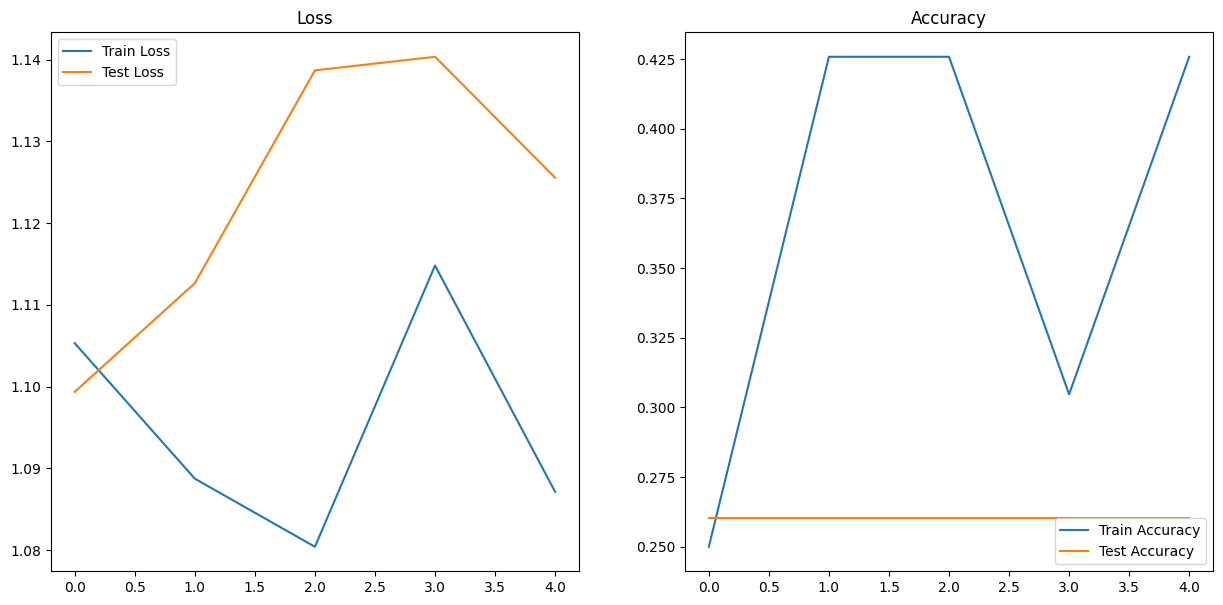

In [63]:
plot_loss_curves(model_0_results)